<a href="https://colab.research.google.com/github/ThienNguyen1113/Chicken_Duck_Prediction/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import os
import io
import zipfile
import numpy as np
import matplotlib as plt
import matplotlib.image as mpimg
import cv2 as cv
from rembg import remove
from PIL import Image
from skimage import feature
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, classification_report, log_loss
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import seaborn as sns

In [ ]:
print(cv.__version__)

4.10.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_update.zip to dataset_update.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_name = 'dataset_update.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/final_project')

print("Files extracted to: /content/final_project")

# List the extracted files
print(os.listdir('/content/final_project/dataset_update'))

Files extracted to: /content/final_project
['Other', 'Duck', 'Chicken']


In [ ]:
dataset_path = '/content/final_project/dataset_update'
X = [] # dataset
for folder in os.listdir(dataset_path):
  for img in os.listdir(dataset_path + '/' + folder):

    img_path = os.path.join(dataset_path, folder, img)
    X.append(img_path)

Img2Label = {
    "Chicken": 0,
    "Duck"   : 1,
    "Other"  : 2,
}

Y = [] # Label
for data in X:
  if 'Chicken' in data:
    Y.append(Img2Label['Chicken'])
  elif 'Duck' in data:
    Y.append(Img2Label['Duck'])
  elif 'Other' in data:
    Y.append(Img2Label['Other'])

Y = np.array(Y, dtype=np.float32)
Y.shape

(300,)

#Feature Extraction

**Pre processing data (graph cut)**

In [ ]:
def Cut_Background(img_path):
    # Đọc ảnh đầu vào
    with open(img_path, 'rb') as file:
        input_image = file.read()

    # Loại bỏ background bằng rembg
    output_image = remove(input_image)

    # Chuyển đổi ảnh đầu ra thành định dạng numpy array để sử dụng với OpenCV
    output_pil = Image.open(io.BytesIO(output_image)).convert("RGBA")  # RGBA để giữ nền trong suốt
    output_np = np.array(output_pil)

    # Tách các kênh ảnh (nếu cần sử dụng với OpenCV)
    if output_np.shape[2] == 4:  # RGBA
        rgb_image = output_np[:, :, :3]  # Lấy kênh RGB
        alpha_channel = output_np[:, :, 3]  # Kênh alpha
        return rgb_image  # Trả về ảnh RGB
    else:
        return output_np

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 63.4GB/s]


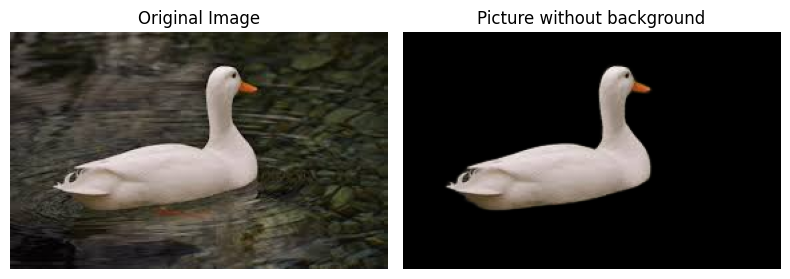

In [ ]:
img_no_bg = Cut_Background(X[119])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(cv.imread(X[119]), cv.COLOR_BGR2RGB))  # Hiển thị ảnh gốc
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_no_bg)
plt.title("Picture without background")
plt.axis("off")

plt.tight_layout()
plt.show()

1. HOG

Có cắt BackGround

In [ ]:
def extract_hog_features_no_BG(img_path):
    img_no_bg = Cut_Background(img_path)

    img_no_bg = cv.resize(img_no_bg, (256, 256))

    # Trích xuất đặc trưng HOG từ ảnh đã xóa background
    (hog_features, hog_image) = feature.hog(img_no_bg, orientations=9,
                                            pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2),
                                            block_norm='L2-Hys',
                                            visualize=True,
                                            transform_sqrt=True,
                                            channel_axis=-1)

    return hog_features, hog_image

Không cắt BackGround

In [ ]:
def extract_hog_features(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (256, 256))

    # Trích xuất đặc trưng HOG từ ảnh đã xóa background
    (hog_features, hog_image) = feature.hog(img, orientations=9,
                                            pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2),
                                            block_norm='L2-Hys',
                                            visualize=True,
                                            transform_sqrt=True,
                                            channel_axis=-1)

    return hog_features, hog_image

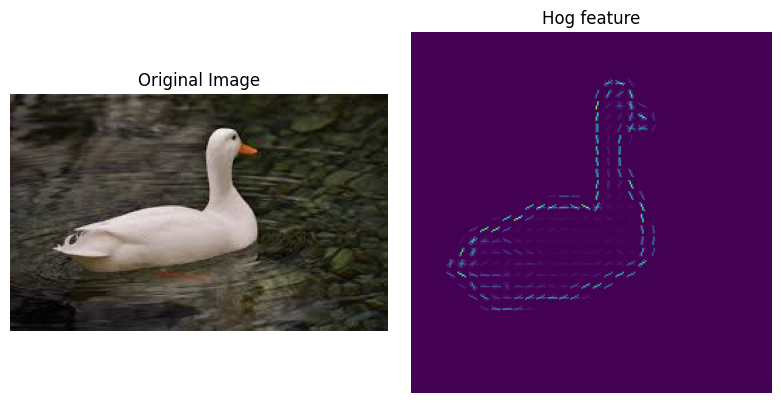

In [ ]:
_, hog_image = extract_hog_features_no_BG(X[119])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(cv.imread(X[119]), cv.COLOR_BGR2RGB))  # Hiển thị ảnh gốc
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
# Display the hog_image instead of show_img
plt.imshow(hog_image)
plt.title("Hog feature")
plt.axis("off")

plt.tight_layout()
plt.show()

2. ORB

2.1 ORB chưa cập nhật


In [ ]:
def extract_ORB_features(img_path):
    img_no_bg = Cut_Background(img_path)

    img_no_bg = cv.resize(img_no_bg, (256, 256))

    # Trích xuất đặc trưng ORB từ ảnh đã xóa background
    orb = cv.ORB_create(nfeatures=100)
    kp, des = orb.detectAndCompute(img_no_bg, None)

    # Kiểm tra nếu không có đặc trưng được phát hiện
    if des is not None:
        # Pad với giá trị -1 nếu thiếu
        des = des[:68] if len(des) >= 68 else np.pad(des, ((0, 68 - len(des)), (0, 0)), constant_values=-1)
    else:
        des = np.full((68, 32), -1)

    img_with_keypoints = cv.drawKeypoints(img_no_bg, kp, None, color=(0, 255, 0))

    return img_with_keypoints, des

2.2 ORB đã cập nhật

> Ứng dụng SIFT xử lý các hạn chế của ORB



In [ ]:
def new_extract_ORB_features(img_path):
    img = cv.imread(img_path)

    img = cv.resize(img, (256, 256))

    # Trích xuất đặc trưng ORB từ ảnh đã xóa background
    sift = cv.SIFT_create()

    kp, des = sift.detectAndCompute(img,None)
    if des is not None:
        # Pad với giá trị -1 nếu thiếu
        des = des[:68] if len(des) >= 68 else np.pad(des, ((0, 68 - len(des)), (0, 0)), constant_values=-1)
    else:
        des = np.full((68, 32), -1)

    img_with_keypoints=cv.drawKeypoints(img, kp, None, color=(0, 255, 0))

    return img_with_keypoints, des

In [ ]:
def new_extract_ORB_features_no_BG(img_path):
    img_no_bg = Cut_Background(img_path)

    img_no_bg = cv.resize(img_no_bg, (256, 256))

    # Trích xuất đặc trưng ORB từ ảnh đã xóa background
    sift = cv.SIFT_create()

    kp, des = sift.detectAndCompute(img_no_bg,None)
    if des is not None:
        # Pad với giá trị -1 nếu thiếu
        des = des[:68] if len(des) >= 68 else np.pad(des, ((0, 68 - len(des)), (0, 0)), constant_values=-1)
    else:
        des = np.full((68, 32), -1)

    img_with_keypoints=cv.drawKeypoints(img_no_bg, kp, None, color=(0, 255, 0))

    return img_with_keypoints, des

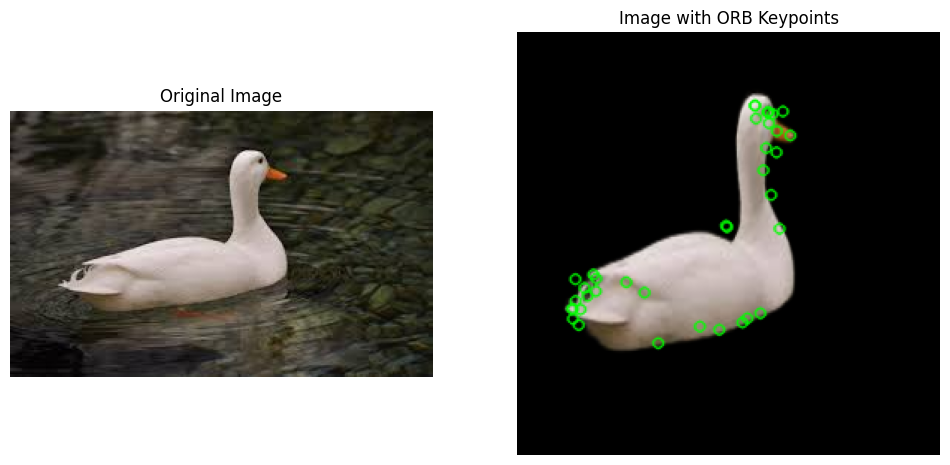

In [ ]:
img ,__ = new_extract_ORB_features_no_BG(X[119])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(cv.imread(X[119]), cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title("Image with ORB Keypoints")
plt.axis("off")

plt.show()

## Trích xuất đặc trưng

In [ ]:
hog_features_without_BG = []
orb_features_without_BG = []
hog_features_with_BG = []
orb_features_with_BG = []

for img in X:
  hog_feature_1, __ = extract_hog_features_no_BG(img)
  __, sift_descriptor_1 = new_extract_ORB_features_no_BG(img)

  hog_features_without_BG.append(hog_feature_1)
  orb_features_without_BG.append(sift_descriptor_1)

  hog_feature_2, __ = extract_hog_features(img)
  __, sift_descriptor_2 = new_extract_ORB_features(img)

  hog_features_with_BG.append(hog_feature_2)
  orb_features_with_BG.append(sift_descriptor_2)



In [ ]:
hog_features_without_BG = np.array(hog_features_without_BG)

max_len = 0  # Initialize max_len to find the maximum length

# Find the maximum length of the flattened ORB features
for orb_descriptor in orb_features_without_BG:
    flattened_len = orb_descriptor.flatten().shape[0]
    max_len = max(max_len, flattened_len)

flattened_orb_features_without_BG = []
# Pad or truncate to ensure uniform length
for orb_descriptor in orb_features_without_BG:
    flattened = orb_descriptor.flatten()
    if flattened.shape[0] < max_len:
        # Pad with zeros to reach max_len
        padded = np.pad(flattened, (0, max_len - flattened.shape[0]), 'constant')
        flattened_orb_features_without_BG.append(padded)
    else:
        # Truncate to max_len
        flattened_orb_features_without_BG.append(flattened[:max_len])

orb_features_without_BG = np.array(flattened_orb_features_without_BG)

hog_features_with_BG = np.array(hog_features_with_BG)

# Repeat the same padding/truncating process for orb_features_with_BG
flattened_orb_features_with_BG = []
for orb_descriptor in orb_features_with_BG:
    flattened = orb_descriptor.flatten()
    if flattened.shape[0] < max_len:
        padded = np.pad(flattened, (0, max_len - flattened.shape[0]), 'constant')
        flattened_orb_features_with_BG.append(padded)
    else:
        flattened_orb_features_with_BG.append(flattened[:max_len])

orb_features_with_BG = np.array(flattened_orb_features_with_BG)

In [ ]:
for i in range(len(orb_features_without_BG)):
  print(f"Shape of feature_vector: {orb_features_without_BG[i].shape}")

Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of feature_vector: (8704,)
Shape of f

In [ ]:
# Flatten ORB features
flattened_orb_features_without_BG = orb_features_without_BG.reshape(orb_features_without_BG.shape[0], -1)
flattened_orb_features_with_BG = orb_features_with_BG.reshape(orb_features_with_BG.shape[0], -1)

# Chia dữ liệu thành tập train và test
X_train_1, X_test_1, y_train_1, y_test_1, img_train_1, img_test_1 = train_test_split(hog_features_without_BG, Y, X , test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2, img_train_2, img_test_2 = train_test_split(flattened_orb_features_without_BG, Y, X, test_size=0.2, random_state=42)

X_train_3, X_test_3, y_train_3, y_test_3, img_train_3, img_test_3 = train_test_split(hog_features_with_BG, Y, X , test_size=0.2, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4, img_train_4, img_test_4 = train_test_split(flattened_orb_features_with_BG, Y, X, test_size=0.2, random_state=42)

In [ ]:
def get_correct_incorrect_images(img_list, y_true, y_pred):
    labels = ["Chicken", "Duck", "Other"]

    correct_images_dict = {label: [] for label in labels}
    incorrect_images_dict = {label: [] for label in labels}

    for label in labels:
        label_index = labels.index(label)  # Lấy index của nhãn

        # Lọc các ảnh đúng và sai theo nhãn
        correct_images = []
        incorrect_images = []

        for img, true, pred in zip(img_list, y_true, y_pred):
            if true == pred :  # Dự đoán đúng cho nhãn này
                correct_images.append(img)
            elif true != pred :  # Dự đoán sai cho nhãn này
                incorrect_images.append(img)

    # Tạo các danh sách rỗng cho từng nhãn và phân loại ảnh đúng và sai
    chicken_true, chicken_false = [], []
    duck_true, duck_false = [], []
    other_true, other_false = [], []

    # Duyệt qua các ảnh đúng
    for img in correct_images:
        if 'Chicken' in img:
            chicken_true.append(img)
        elif 'Duck' in img:
            duck_true.append(img)
        elif 'Other' in img:
            other_true.append(img)

    # Duyệt qua các ảnh sai
    for img in incorrect_images:
        if 'Chicken' in img:
            chicken_false.append(img)
        elif 'Duck' in img:
            duck_false.append(img)
        elif 'Other' in img:
            other_false.append(img)

    return chicken_true, chicken_false, duck_true, duck_false, other_true, other_false


    import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lọc ảnh đúng và sai từ các danh sách, với số lượng ảnh đúng và sai cho từng nhãn
def get_limited_images(chicken_true, chicken_false, duck_true, duck_false, other_true, other_false, true_count=2, false_count=3):
    # Lấy tối đa số ảnh đúng và sai cho từng nhãn
    chicken_true_limited = chicken_true[:true_count]
    chicken_false_limited = chicken_false[:false_count]

    duck_true_limited = duck_true[:true_count]
    duck_false_limited = duck_false[:false_count]

    other_true_limited = other_true[:true_count]
    other_false_limited = other_false[:false_count]

    return {
        'chicken_true': chicken_true_limited,
        'chicken_false': chicken_false_limited,
        'duck_true': duck_true_limited,
        'duck_false': duck_false_limited,
        'other_true': other_true_limited,
        'other_false': other_false_limited,
    }

# Hàm hiển thị ảnh theo nhóm
def display_images_with_plots(image_list, title="Images"):
    plt.figure(figsize=(10, 10))  # Tạo figure lớn để chứa ảnh
    for idx, img_path in enumerate(image_list):
        img = mpimg.imread(img_path)  # Đọc ảnh từ đường dẫn
        plt.subplot(1, len(image_list), idx + 1)  # Đặt ảnh vào các vị trí khác nhau
        plt.imshow(img)  # Hiển thị ảnh
        plt.axis('off')  # Tắt hiển thị trục
    plt.suptitle(title, fontsize=16)  # Tiêu đề cho các ảnh
    plt.show()  # Hiển thị các ảnh kết hợp

# Hàm hiển thị tất cả ảnh đã lọc theo từng nhóm
def display_limited_images(chicken_true, chicken_false, duck_true, duck_false, other_true, other_false, true_count=2, false_count=3):
    limited_images = get_limited_images(chicken_true, chicken_false, duck_true, duck_false, other_true, other_false, true_count, false_count)

    # Duyệt qua các nhóm ảnh để hiển thị
    for label, images in limited_images.items():
        title = f"{label.replace('_', ' ').capitalize()}"
        display_images_with_plots(images, title=title)


#Support Vector Machine_Thiện

Chọn tham số phù hợp nhất cho mô hình

In [ ]:
# Define the parameter grid for SVM
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [ 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Grid Search for HOG features
grid_search_1 = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search_1.fit(X_train_1, y_train_1)

# Best parameters and model for HOG
print("Best parameters for HOG features without BackGround:", grid_search_1.best_params_)
best_model_1 = grid_search_1.best_estimator_

# Grid Search for ORB features
grid_search_2 = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search_2.fit(X_train_2, y_train_2)

# Best parameters and model for ORB
print("Best parameters for ORB features without BackGround:", grid_search_2.best_params_)
best_model_2 = grid_search_2.best_estimator_

# Grid Search for HOG features without background
grid_search_3 = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search_3.fit(X_train_3, y_train_3)

# Best parameters and model for HOG without background
print("Best parameters for HOG features:", grid_search_1.best_params_)
best_model_3 = grid_search_3.best_estimator_

# Grid Search for ORB features without background
grid_search_4 = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search_4.fit(X_train_4, y_train_4)

# Best parameters and model for ORB without background
print("Best parameters for ORB features:", grid_search_2.best_params_)
best_model_4 = grid_search_4.best_estimator_

Best parameters for HOG features: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best parameters for ORB features: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for HOG features: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best parameters for ORB features: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Xây dựng mô hình với tham số tốt nhất đã tìm được

Accuracy (HOG features): 0.6833333333333333

Classification Report (HOG features):
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        22
         1.0       0.46      0.69      0.55        16
         2.0       0.79      0.50      0.61        22

    accuracy                           0.68        60
   macro avg       0.70      0.68      0.67        60
weighted avg       0.73      0.68      0.69        60



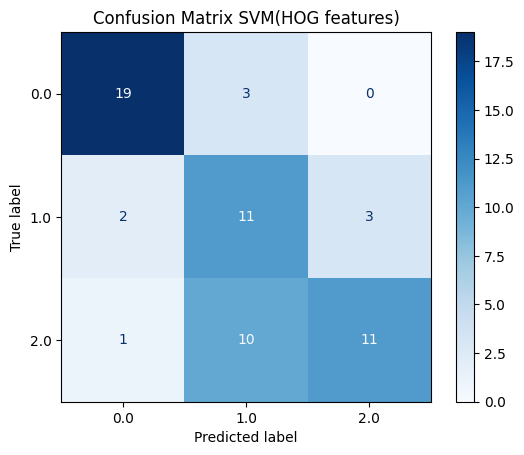

--------------------------------------------------------------------------------------------------------------
Accuracy (ORB features): 0.45

Classification Report (ORB features):
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50        22
         1.0       0.32      0.44      0.37        16
         2.0       0.56      0.41      0.47        22

    accuracy                           0.45        60
   macro avg       0.46      0.45      0.45        60
weighted avg       0.47      0.45      0.46        60



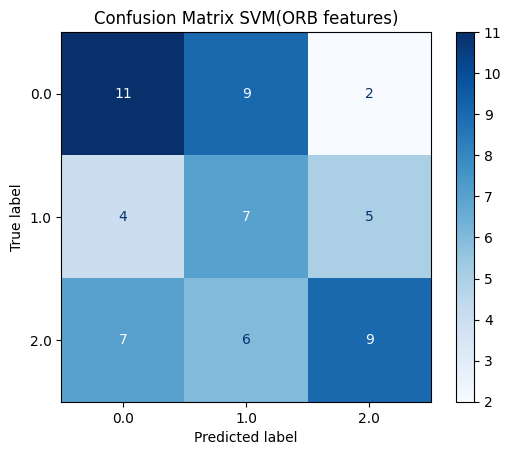

--------------------------------------------------------------------------------------------------------------
Accuracy (HOG features without background): 0.45

Classification Report (HOG features without background):
               precision    recall  f1-score   support

         0.0       1.00      0.05      0.09        22
         1.0       0.50      0.44      0.47        16
         2.0       0.42      0.86      0.57        22

    accuracy                           0.45        60
   macro avg       0.64      0.45      0.37        60
weighted avg       0.65      0.45      0.36        60



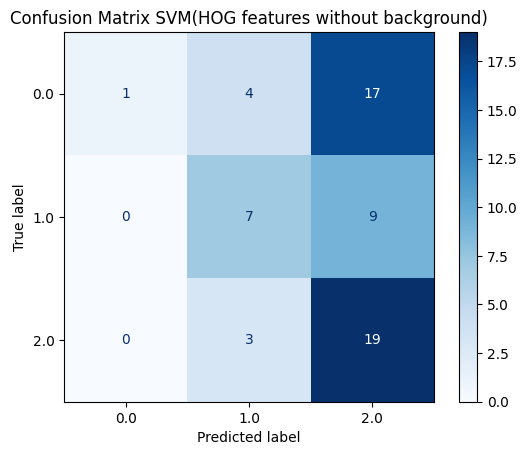

--------------------------------------------------------------------------------------------------------------
Accuracy (ORB features without background): 0.4666666666666667

Classification Report (ORB features without background):
               precision    recall  f1-score   support

         0.0       0.44      0.50      0.47        22
         1.0       0.42      0.62      0.50        16
         2.0       0.64      0.32      0.42        22

    accuracy                           0.47        60
   macro avg       0.50      0.48      0.46        60
weighted avg       0.51      0.47      0.46        60



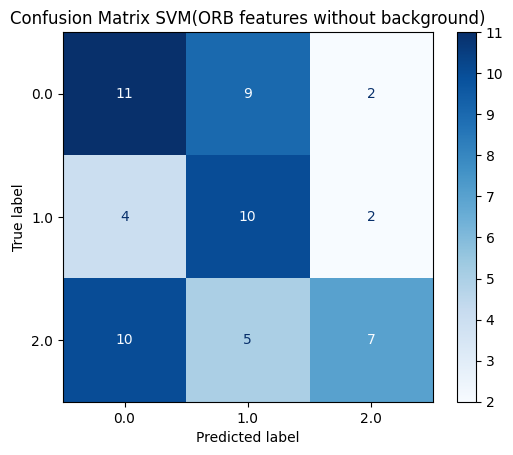

In [ ]:
# Train mô hình SVM cho đặc trưng HOG
model_1 = SVC(kernel='sigmoid', C=1, gamma='scale', random_state=42)
model_1.fit(X_train_1, y_train_1)

# Train mô hình SVM cho đặc trưng ORB
model_2 = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
model_2.fit(X_train_2, y_train_2)

# Train mô hình SVM cho đặc trưng HOG
model_3 = SVC(kernel='sigmoid', C=1, gamma='scale', random_state=42)
model_3.fit(X_train_3, y_train_3)

# Train mô hình SVM cho đặc trưng ORB
model_4 = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
model_4.fit(X_train_4, y_train_4)

# Đánh giá mô hình
y_1_pred = model_1.predict(X_test_1)
y_2_pred = model_2.predict(X_test_2)
y_3_pred = model_3.predict(X_test_3)
y_4_pred = model_4.predict(X_test_4)

conf_matrix_1 = confusion_matrix(y_test_1, y_1_pred)
conf_matrix_2 = confusion_matrix(y_test_2, y_2_pred)
conf_matrix_3 = confusion_matrix(y_test_3, y_3_pred)
conf_matrix_4 = confusion_matrix(y_test_4, y_4_pred)

# In kết quả
print("Accuracy (HOG features):", accuracy_score(y_test_1, y_1_pred))
print("\nClassification Report (HOG features):\n", classification_report(y_test_1, y_1_pred))


disp_1 = ConfusionMatrixDisplay(conf_matrix_1, display_labels=model_1.classes_)
disp_1.plot(cmap='Blues')
plt.title("Confusion Matrix SVM(HOG features)")
plt.show()

print("-" * 110)
print("Accuracy (ORB features):", accuracy_score(y_test_2, y_2_pred))
print("\nClassification Report (ORB features):\n", classification_report(y_test_2, y_2_pred))


disp_2 = ConfusionMatrixDisplay(conf_matrix_2, display_labels=model_2.classes_)
disp_2.plot(cmap='Blues')
plt.title("Confusion Matrix SVM(ORB features)")
plt.show()

print("-" * 110)
print("Accuracy (HOG features without background):", accuracy_score(y_test_3, y_3_pred))
print("\nClassification Report (HOG features without background):\n", classification_report(y_test_3, y_3_pred))

disp_3 = ConfusionMatrixDisplay(conf_matrix_3, display_labels=model_3.classes_)
disp_3.plot(cmap='Blues')
plt.title("Confusion Matrix SVM(HOG features without background)")
plt.show()

print("-" * 110)
print("Accuracy (ORB features without background):", accuracy_score(y_test_4, y_4_pred))
print("\nClassification Report (ORB features without background):\n", classification_report(y_test_4, y_4_pred))


disp_4 = ConfusionMatrixDisplay(conf_matrix_4, display_labels=model_4.classes_)
disp_4.plot(cmap='Blues')
plt.title("Confusion Matrix SVM(ORB features without background)")
plt.show()

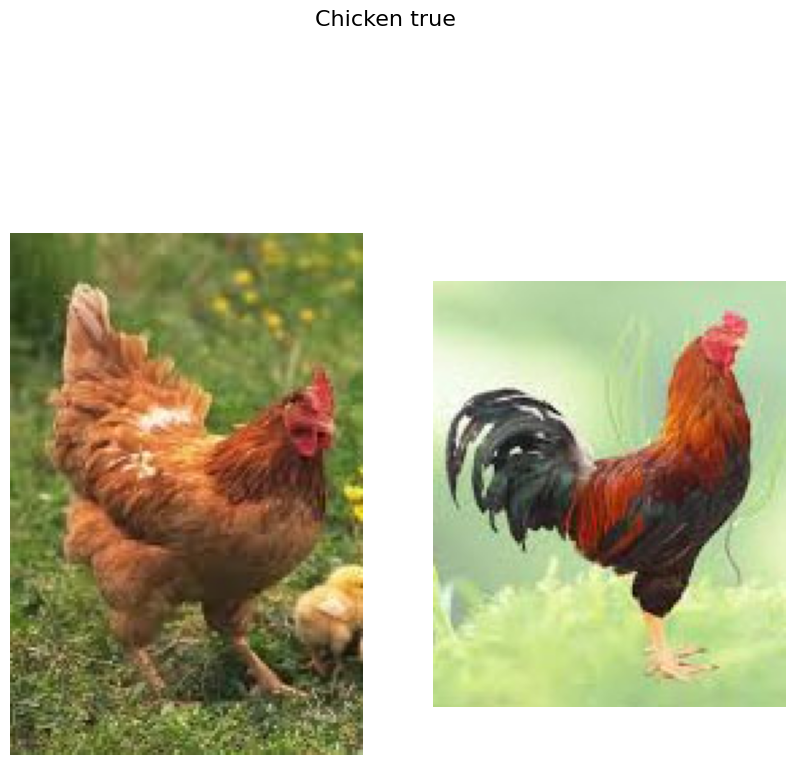

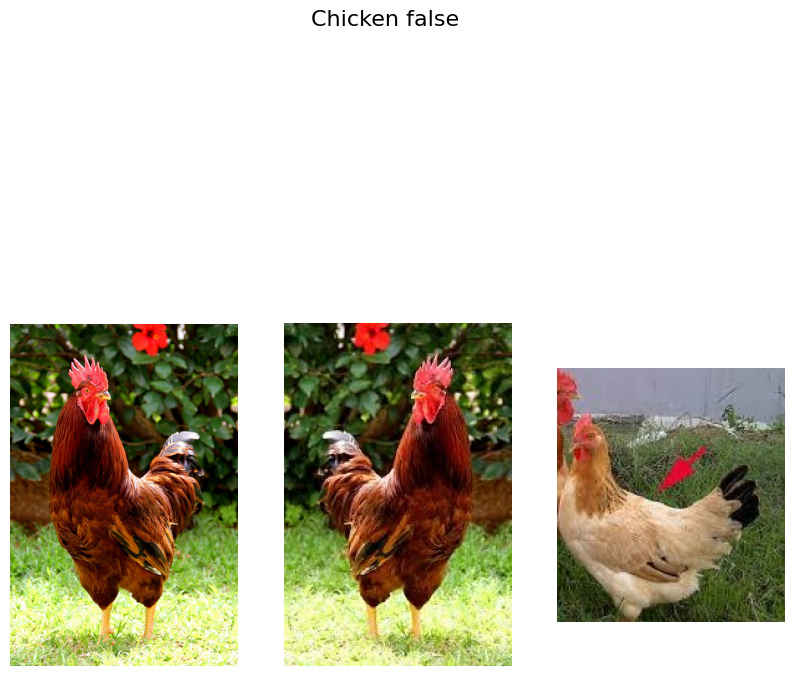

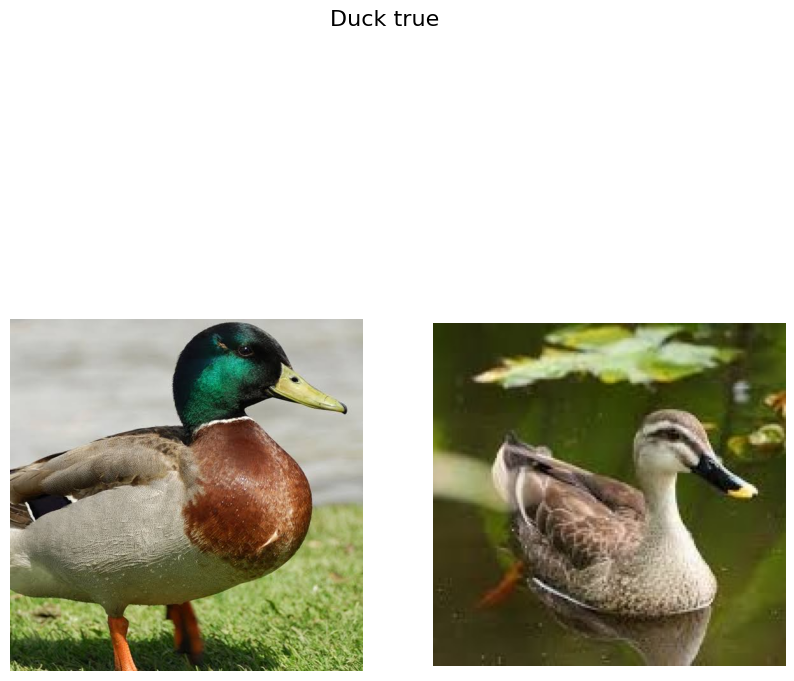

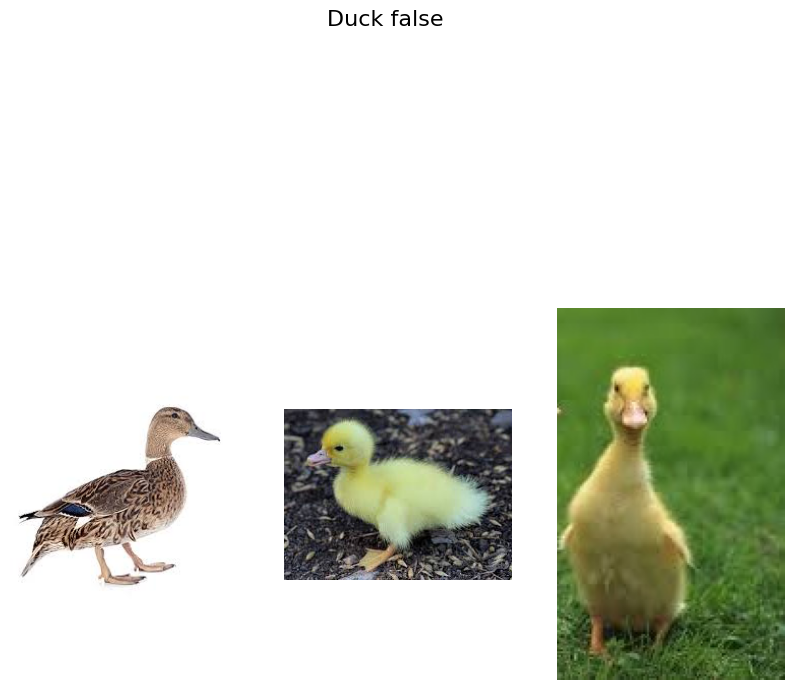

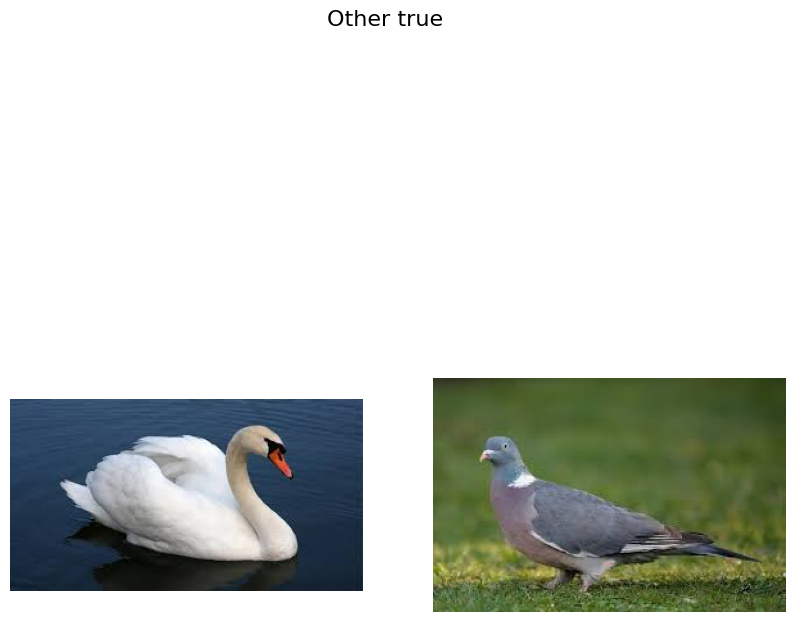

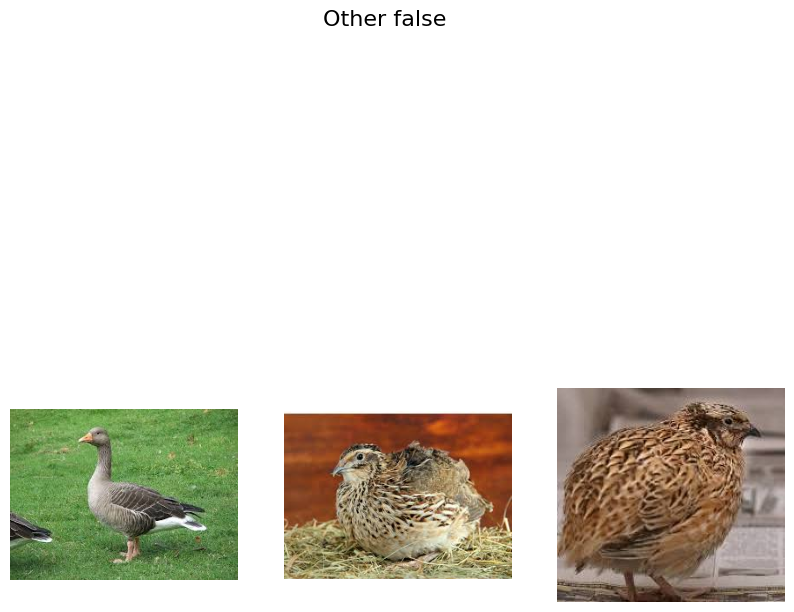

In [ ]:
chicken_true, chicken_false, duck_true, duck_false, other_true, other_false = get_correct_incorrect_images(img_test_1, y_test_1, y_1_pred)
display_limited_images(chicken_true, chicken_false, duck_true, duck_false, other_true, other_false, true_count=2, false_count=2)

#SoftMax_Regression_Thịnh

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for HOG: {'C': 100, 'max_iter': 5000, 'solver': 'lbfgs'}


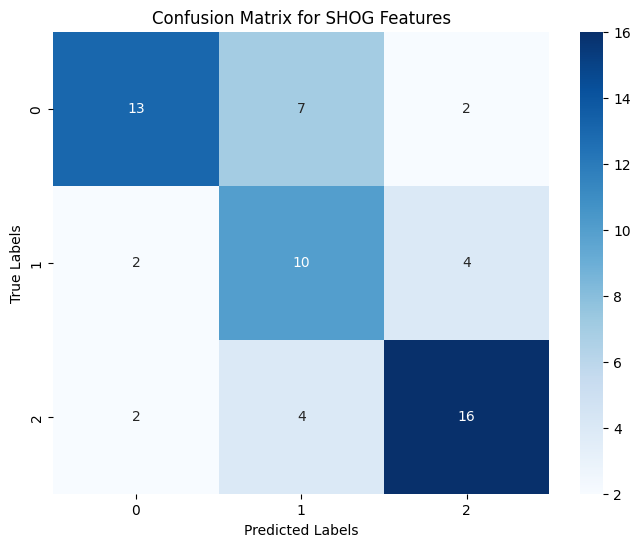

--------------------------------------------------------------------------------------------------------------
Accuracy (HOG features): 0.65

Classification Report (HOG features):
               precision    recall  f1-score   support

         0.0       0.76      0.59      0.67        22
         1.0       0.48      0.62      0.54        16
         2.0       0.73      0.73      0.73        22

    accuracy                           0.65        60
   macro avg       0.66      0.65      0.64        60
weighted avg       0.67      0.65      0.66        60

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for ORB: {'C': 10, 'max_iter': 7000, 'solver': 'lbfgs'}
Accuracy on test set (ORB): 36.67%
Log Loss on test set (ORB): 6.9696


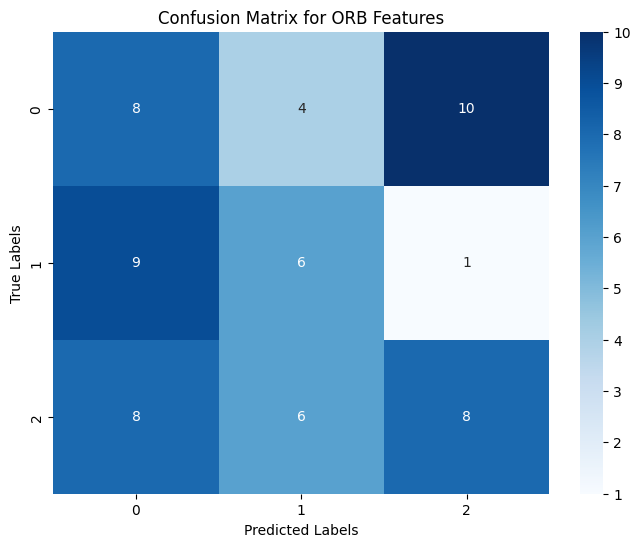

--------------------------------------------------------------------------------------------------------------
Accuracy (ORB features): 0.36666666666666664

Classification Report (ORB features):
               precision    recall  f1-score   support

         0.0       0.32      0.36      0.34        22
         1.0       0.38      0.38      0.38        16
         2.0       0.42      0.36      0.39        22

    accuracy                           0.37        60
   macro avg       0.37      0.37      0.37        60
weighted avg       0.37      0.37      0.37        60



In [ ]:
# Định nghĩa grid search
param_grid = {
    'C': [ 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'max_iter': [5000]
}

# Khởi tạo LogisticRegression và GridSearchCV cho HOG
model_hog = LogisticRegression(random_state=42)
grid_hog = GridSearchCV(estimator=model_hog, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_hog.fit(X_train_1, y_train_1)

# Kết quả tốt nhất cho HOG
best_params_hog = grid_hog.best_params_
best_model_hog = grid_hog.best_estimator_
print("Best parameters for HOG:", best_params_hog)

# Đánh giá mô hình tốt nhất trên tập test
y_test_pred_hog = best_model_hog.predict(X_test_1)
accuracy_hog = accuracy_score(y_test_1, y_test_pred_hog)
y_test_pred_probs_hog = best_model_hog.predict_proba(X_test_1)
log_loss_hog = log_loss(y_test_1, y_test_pred_probs_hog)


# Vẽ confusion matrix cho HOG
conf_matrix_hog = confusion_matrix(y_test_1, y_test_pred_hog)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_hog, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SHOG Features')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("-" * 110)
print("Accuracy (HOG features):", accuracy_score(y_test_1, y_test_pred_hog))
print("\nClassification Report (HOG features):\n", classification_report(y_test_1, y_test_pred_hog))


# Tương tự cho ORB features

param_grid = {
    'C': [ 0.01, 0.1, 1, 10 ],
    'solver': ['lbfgs'],
    'max_iter': [7000]
}

model_orb = LogisticRegression(random_state=42)
grid_orb = GridSearchCV(estimator=model_orb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_orb.fit(X_train_2, y_train_2)

# Kết quả tốt nhất cho ORB
best_params_orb = grid_orb.best_params_
best_model_orb = grid_orb.best_estimator_
print("Best parameters for ORB:", best_params_orb)

# Đánh giá mô hình tốt nhất trên tập test
y_test_pred_orb = best_model_orb.predict(X_test_2)
accuracy_orb = accuracy_score(y_test_2, y_test_pred_orb)
y_test_pred_probs_orb = best_model_orb.predict_proba(X_test_2)
log_loss_orb = log_loss(y_test_2, y_test_pred_probs_orb)

print(f"Accuracy on test set (ORB): {accuracy_orb * 100:.2f}%")
print(f"Log Loss on test set (ORB): {log_loss_orb:.4f}")

# Vẽ confusion matrix cho ORB
conf_matrix_orb = confusion_matrix(y_test_2, y_test_pred_orb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_orb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for ORB Features')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("-" * 110)
print("Accuracy (ORB features):", accuracy_score(y_test_2, y_test_pred_orb))
print("\nClassification Report (ORB features):\n", classification_report(y_test_2, y_test_pred_orb))


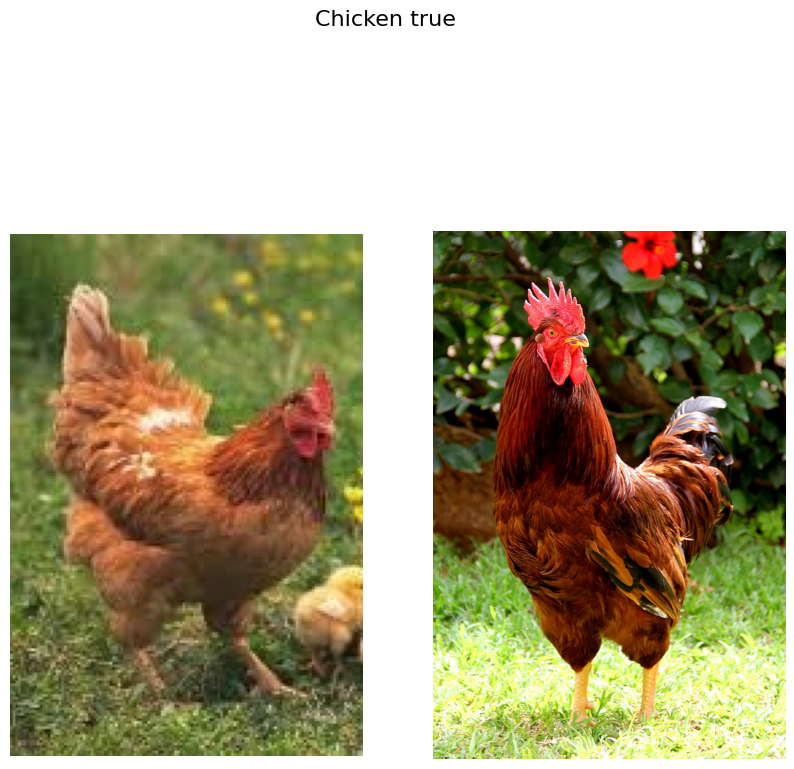

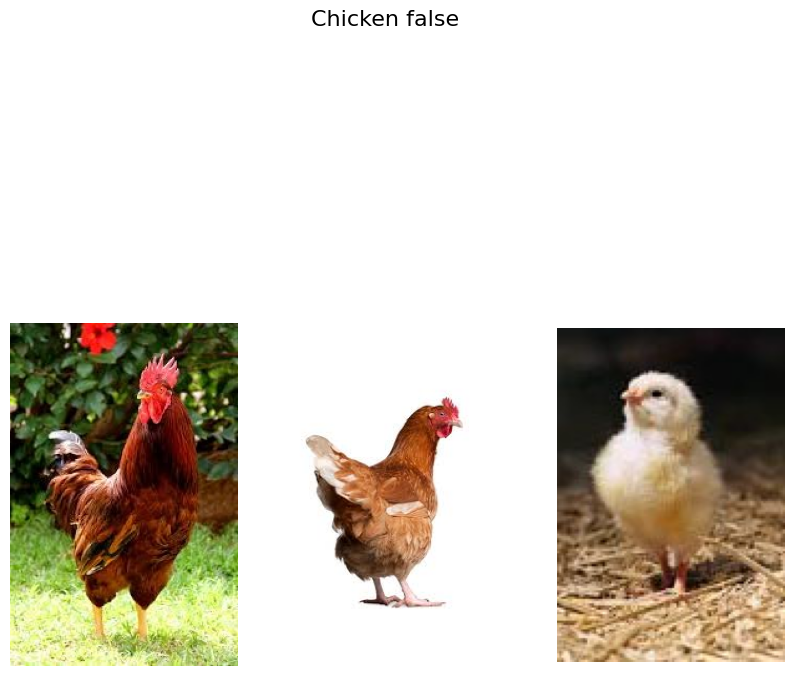

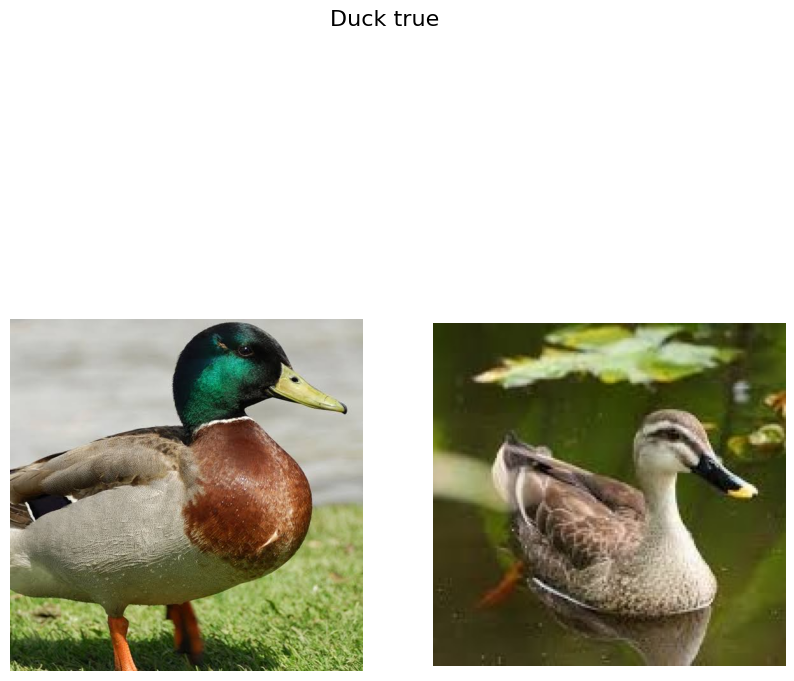

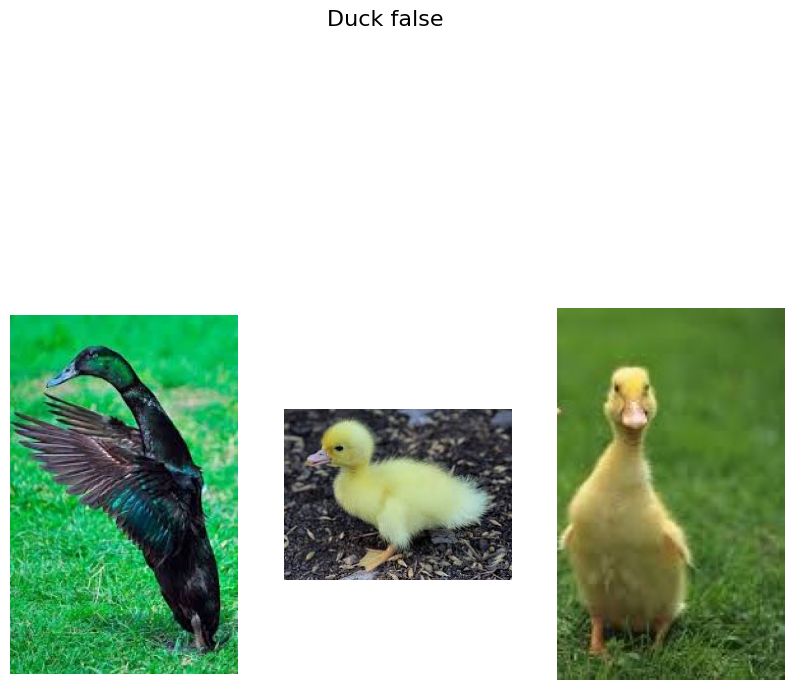

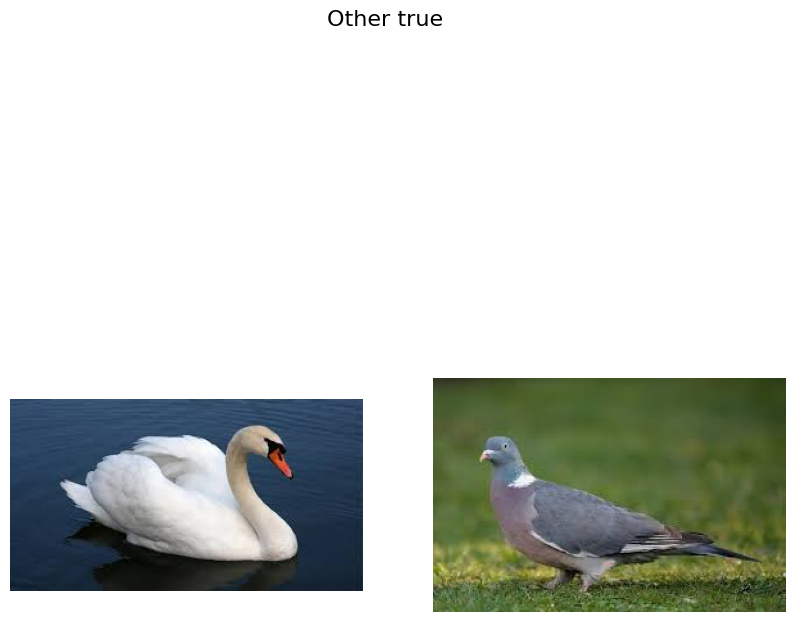

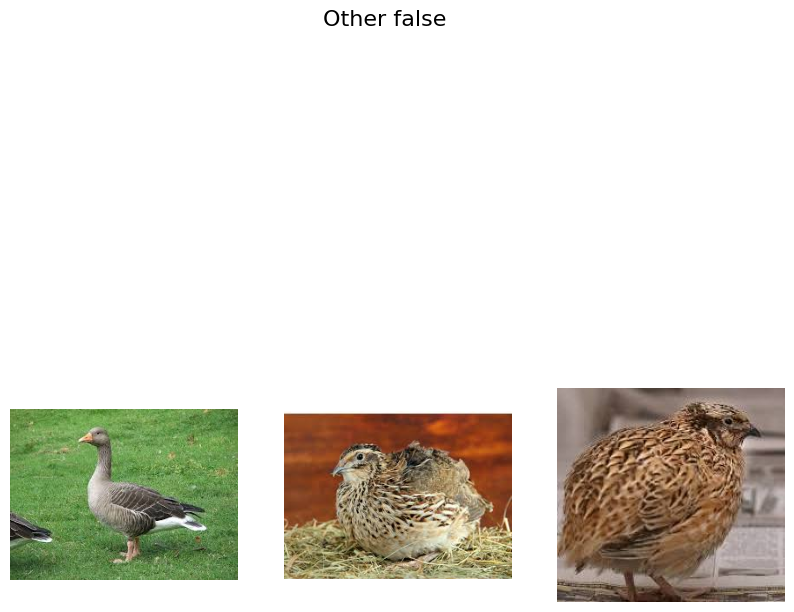

In [ ]:
chicken_true_1, chicken_false_1, duck_true_1, duck_false_1, other_true_1, other_false_1 = get_correct_incorrect_images(img_test_1, y_test_1, y_test_pred_hog )
display_limited_images(chicken_true_1, chicken_false_1, duck_true_1, duck_false_1, other_true_1, other_false_1, true_count=2, false_count=3)

# DỰ ĐOÁN ẢNH

In [ ]:
def predict_image(model_1, model_2, image_path, feature_type='hog'):
    class_names = ['Chicken', 'Duck', 'Other']
    img = cv.imread(image_path)

    # Trích xuất đặc trưng HOG
    hog_feature, _ = extract_hog_features(image_path)

    # Dự đoán với mô hình SVM
    svm_pred = model_1.predict(hog_feature.reshape(1, -1))
    # Dự đoán với mô hình Softmax
    softmax_pred = model_2.predict(hog_feature.reshape(1, -1))

    # Chuyển giá trị dự đoán thành số nguyên
    svm_label = int(svm_pred[0])
    softmax_label = int(softmax_pred[0])


    # Chuyển chỉ số nhãn thành tên nhãn
    hog_pred_class = class_names[svm_label]
    orb_pred_class = class_names[softmax_label]

    # Hiển thị ảnh
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # Tắt trục
    plt.title(f"SVM: {hog_pred_class} | SoftMax: {orb_pred_class}")  #
    plt.show()

    return hog_pred_class, orb_pred_class


Saving tải xuống (2).jpg to tải xuống (2).jpg


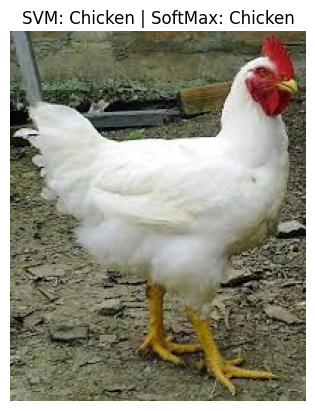

In [ ]:
# Bước 1: Tải ảnh từ máy lên
uploaded = files.upload()

# Bước 2: Lấy đường dẫn file đầu tiên trong các file đã tải lên
image_path = list(uploaded.keys())[0]  # Đường dẫn của hình ảnh

# Bước 3: Gọi hàm dự đoán
hog_class, orb_class = predict_image(model_1, best_model_hog, image_path)


Saving tải xuống (3).jpg to tải xuống (3).jpg


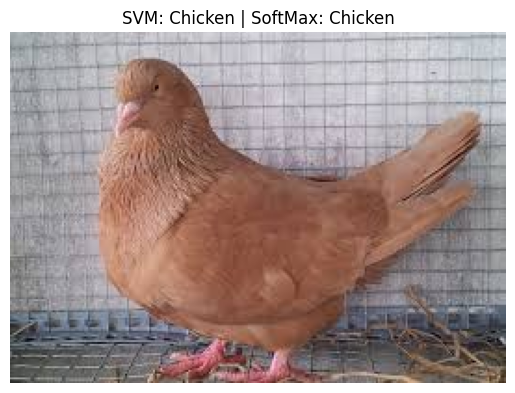

In [ ]:
# Bước 1: Tải ảnh từ máy lên
uploaded = files.upload()

# Bước 2: Lấy đường dẫn file đầu tiên trong các file đã tải lên
image_path = list(uploaded.keys())[0]  # Đường dẫn của hình ảnh

# Bước 3: Gọi hàm dự đoán
hog_class, orb_class = predict_image(model_1, best_model_hog, image_path)
